# Used Cars Scenario

##### You just got a job working for a pre-owned car company in Albuquerque, New Mexico that buys and sells vehicles in the area. You’ve been tasked with determining the asking sales price of a used vehicle based on it’s characteristics.


I'll start out by importing some libraries I think I might need. I may have to import some more later.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
from sqlalchemy import create_engine

Alright, step 1! I'm going to go ahead and load in my data.

In [3]:
sales_data = pd.read_csv('vehicles.csv')
sales_data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


I'm going to check the shape of my dataset really quick just to get an idea of what I'm working with.

In [4]:
sales_data.shape

(426880, 26)

# Splitting and storing data

##### I'm going to start this process by taking a sample of my data, save the sample to a CSV file and remove the sample data from the original dataframe.

In [5]:
sales_data_sample = sales_data.sample(100)
sales_data_sample.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
366644,7304197137,https://beaumont.craigslist.org/ctd/d/beaumont...,beaumont / port arthur,https://beaumont.craigslist.org,21990,2013.0,toyota,tacoma access cab,good,NaN,...,NaN,pickup,red,https://images.craigslist.org/01616_bClCioVzMs...,Carvana is the safer way to buy a car During t...,NaN,tx,30.080000,-94.140000,2021-04-09T11:11:02-0500
334930,7308969612,https://philadelphia.craigslist.org/cto/d/fort...,philadelphia,https://philadelphia.craigslist.org,26990,2016.0,bmw,228i xdrive,excellent,4 cylinders,...,compact,coupe,white,https://images.craigslist.org/00h0h_4tpu3BKnfY...,"Very clean car, with the following packages: M...",NaN,pa,40.138600,-75.202200,2021-04-18T18:09:54-0400
255851,7310624446,https://newjersey.craigslist.org/ctd/d/paterso...,north jersey,https://newjersey.craigslist.org,33995,2013.0,ford,f-450,NaN,NaN,...,NaN,other,white,https://images.craigslist.org/00D0D_aCShhTb4NP...,2013 Ford F-450 SD LARIAT Landscape Dump STAKE...,NaN,nj,40.894535,-74.152367,2021-04-21T19:35:40-0400
107507,7315114236,https://pensacola.craigslist.org/ctd/d/alachua...,pensacola,https://pensacola.craigslist.org,45542,2021.0,ford,explorer limited,NaN,NaN,...,NaN,NaN,NaN,https://images.craigslist.org/00A0A_9YHbXy2eVy...,2021 FORD EXPLORER LIMITED ~ Hundreds of NEW &...,NaN,fl,29.803877,-82.527895,2021-04-30T19:24:19-0500
36109,7313000767,https://merced.craigslist.org/ctd/d/sacramento...,merced,https://merced.craigslist.org,16222,2014.0,honda,cr-v lx,good,4 cylinders,...,NaN,other,blue,https://images.craigslist.org/00V0V_67vME0pk1v...,2014 * Honda * * CR-V LX * suv Twilight Bl...,NaN,ca,38.610767,-121.422557,2021-04-26T13:11:02-0700


In [6]:
sales_data_sample.to_csv('sampled_vehicles.csv', index=False)

In [7]:
sales_index = sales_data_sample.index

sales_data = sales_data.drop(index=sales_index)

##### Alright, I've got a new CSV with my sampled data and removed that data from the original dataset. Now I'm going to upload that raw data into PostgreSQL.

In [8]:
host = r'127.0.0.1'
db = r'MSDS610'
user = r'postgres'
pw = r'MacMVP2025$' 
port = r'5432'
schema = r'raw' 

In [9]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [10]:
table_name = r'sales_data_raw'

In [11]:
sales_data.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

426780

##### Success! Below is a screenshot of pgAdmin showing the new table uploaded to the raw schema.

##### 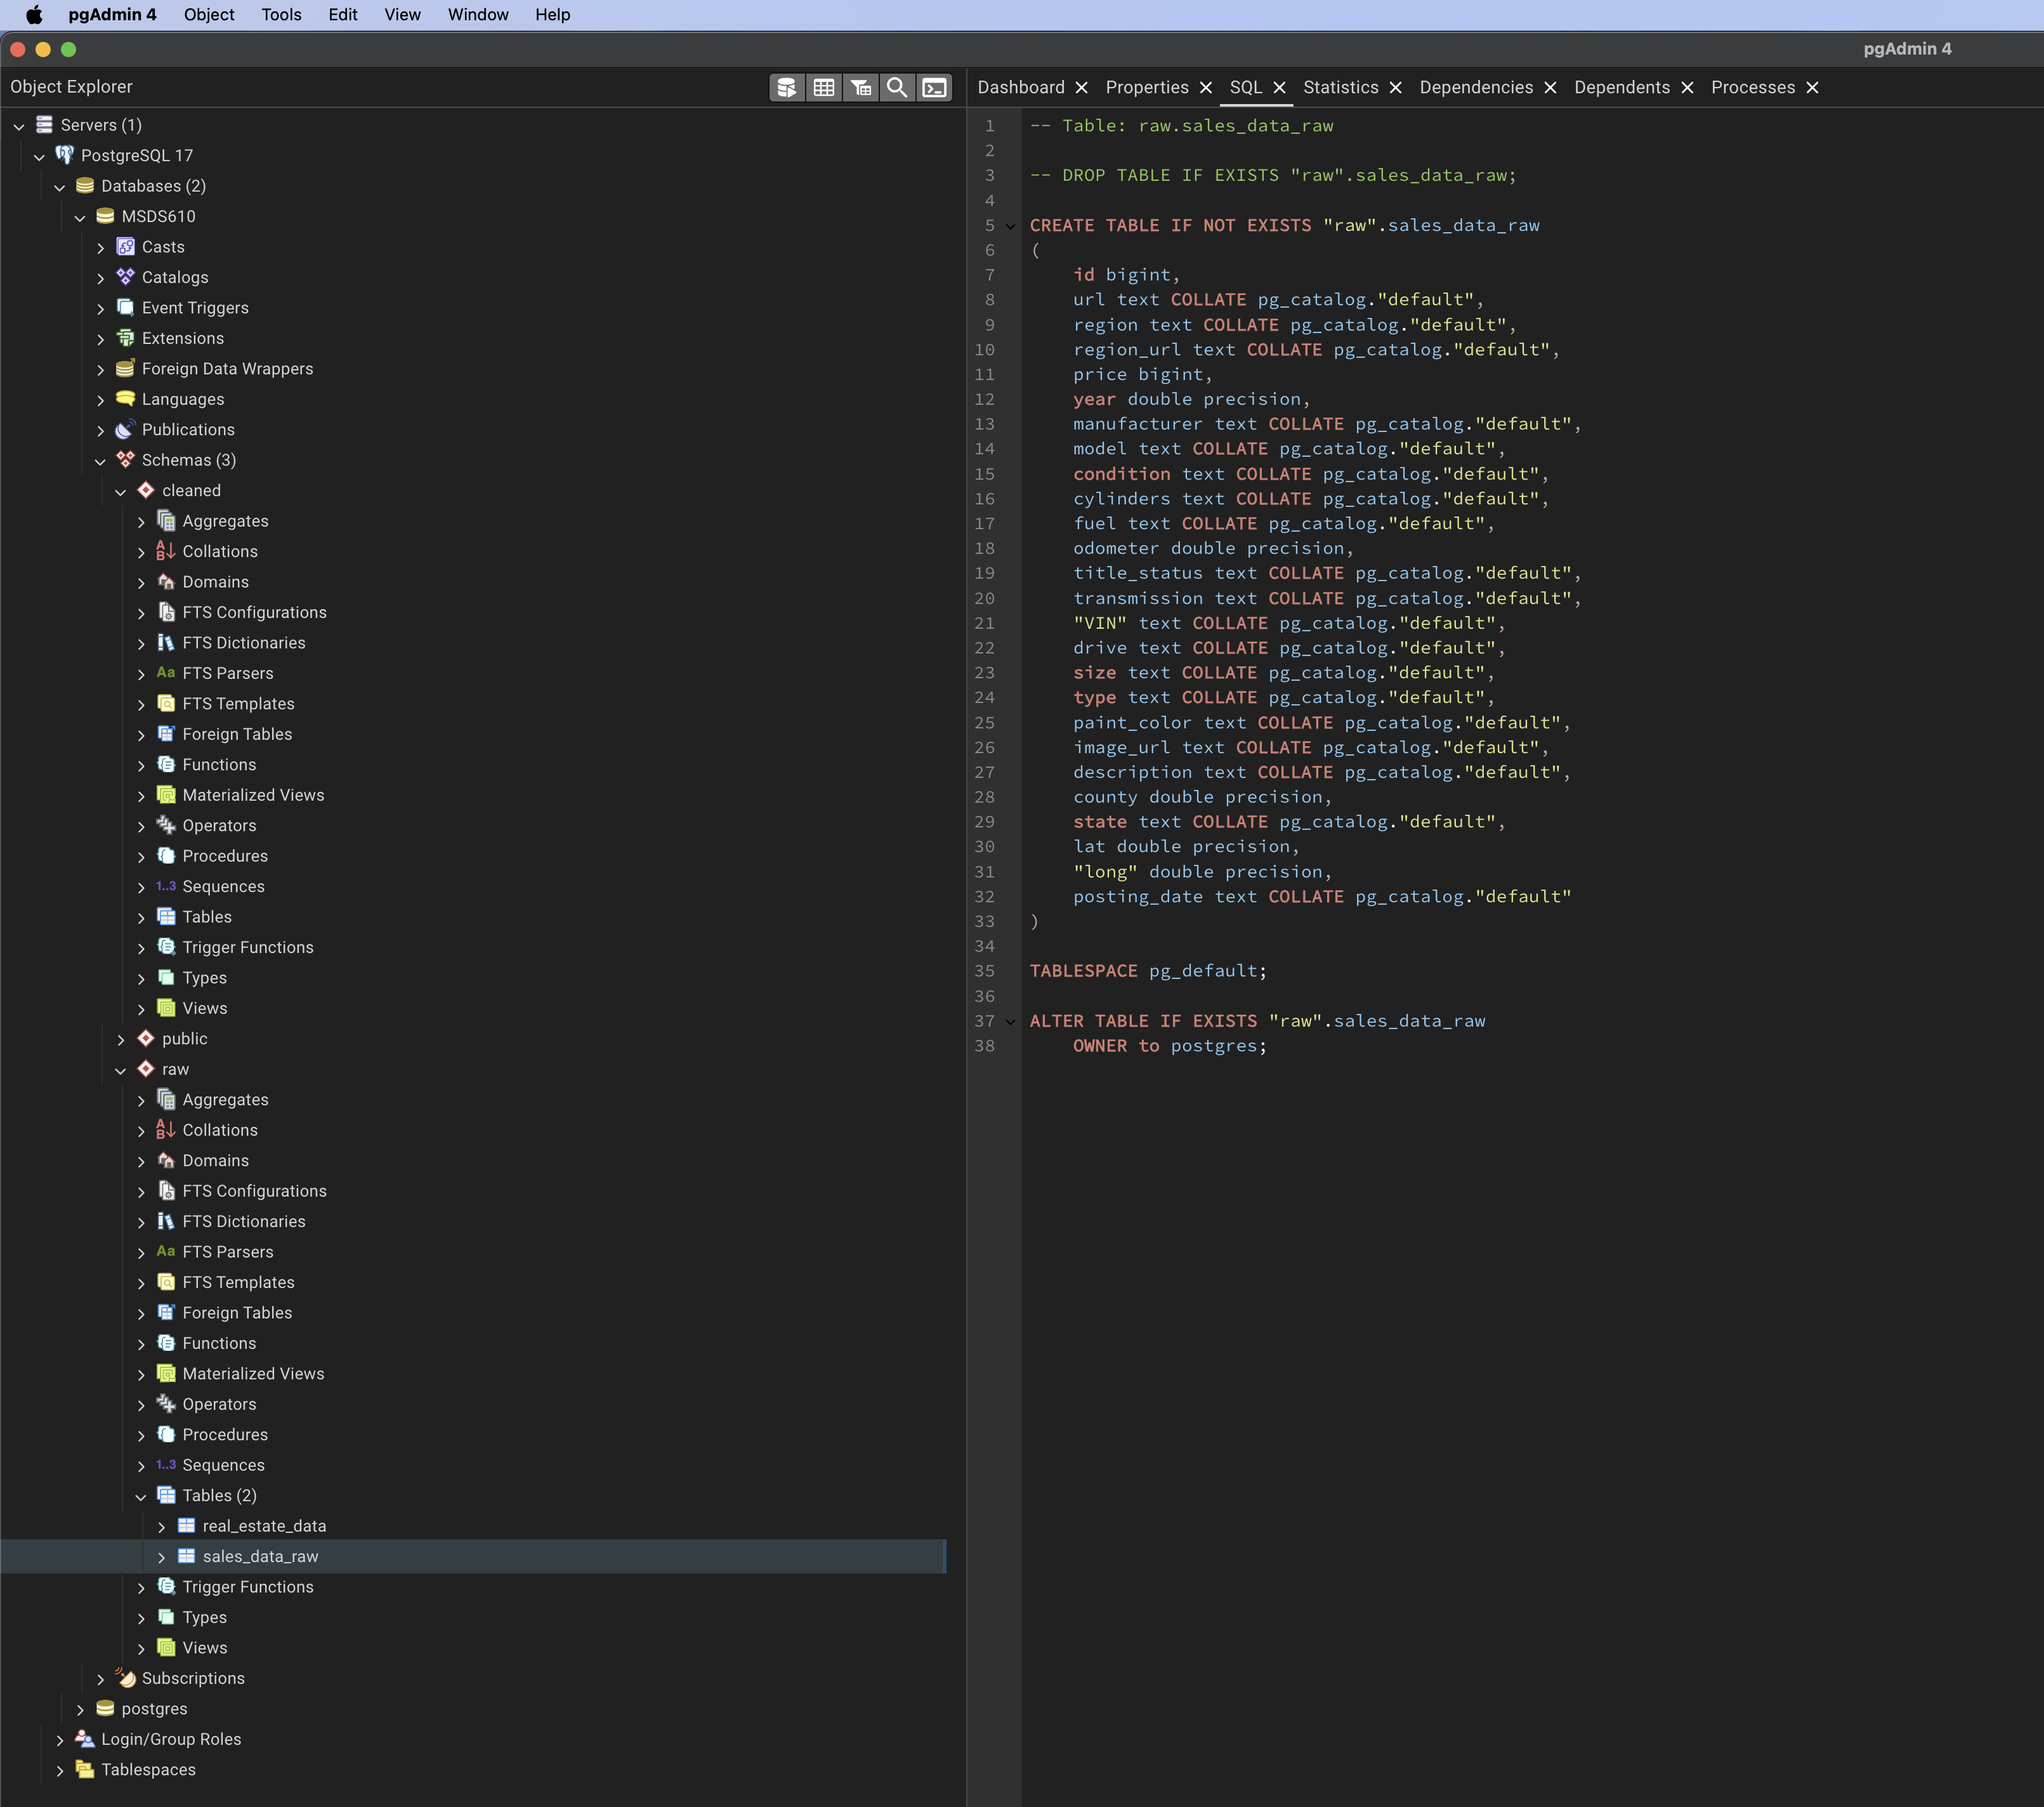

# Data Description

##### Let's go ahead and break down our features and discuss our dataset

In [12]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 426780 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426780 non-null  int64  
 1   url           426780 non-null  object 
 2   region        426780 non-null  object 
 3   region_url    426780 non-null  object 
 4   price         426780 non-null  int64  
 5   year          425575 non-null  float64
 6   manufacturer  409136 non-null  object 
 7   model         421504 non-null  object 
 8   condition     252717 non-null  object 
 9   cylinders     249149 non-null  object 
 10  fuel          423767 non-null  object 
 11  odometer      422383 non-null  float64
 12  title_status  418541 non-null  object 
 13  transmission  424224 non-null  object 
 14  VIN           265773 non-null  object 
 15  drive         296246 non-null  object 
 16  size          120499 non-null  object 
 17  type          333947 non-null  object 
 18  paint_col

In [13]:
sales_data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [14]:
sales_data['fuel'].value_counts

<bound method IndexOpsMixin.value_counts of 0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
           ...  
426875       gas
426876       gas
426877    diesel
426878       gas
426879       gas
Name: fuel, Length: 426780, dtype: object>

In [15]:
sales_data['transmission'].value_counts()

transmission
automatic    336446
other         62666
manual        25112
Name: count, dtype: int64

In [16]:
sales_data['drive'].value_counts()

drive
4wd    131867
fwd    105496
rwd     58883
Name: count, dtype: int64

In [17]:
sales_data['type'].value_counts()

type
sedan          87038
SUV            77269
pickup         43501
truck          35268
other          22104
coupe          19200
hatchback      16596
wagon          10747
van             8547
convertible     7726
mini-van        4825
offroad          609
bus              517
Name: count, dtype: int64

Our dataset represents cars for sale and has descriptive features along with pricing, location, the URL for the posting, and a few others. I'm going to break down each feature below.

1. id: This is nominal data, used as a unique identifier for each of the cars listed.
2. url: This is nominal data, simply the we address where the car is listed for sale.
3. region: This is nominal data, it describes the region where the car is located.
4. region_url: This is nominal data, this shows the web address for the site the car is being sold on but this is just the site for the region not the specific car.
5. price: This is continuous data, it shows the price of the vehicle listed.
6. year: This is discrete data, is describes the model year of the vehicle.
7. manufacturer: This is nominal data, this lists the name of the automaker for the vehicle.
8. model: This is nominal data, it describes what specific vehicle it is.
9. condition: This is ordinal data, it describes how well taken care of the car is.
10. cylinders: This is probably nominal data, but an argument could be made that it's ordinal. It describes the number of cylinders in the engine.
11. fuel: This is nominal data, it describes what kind of fuel the vehicle runs on.
12. odometer: This is continuous data, it describes the number of miles the car has been driven.
13. title_status: This is nominal data, it describes the state of the title, whether it is in good standing or not.
14. transmission: This is nominal data, it describes the mechanism for putting the car into gear.
15. VIN: This is nominal data, it lists a unique identifier for each vehicle. It is recognized widely in contrast to the "id" feature that is only an arbitrary number.
16. drive: This I would call ordinal data, it describes the number of wheels that are powered by the drivetrain.
17. size: This is nominal data, it describes the size of the vehicle.
18. type: This is nominal data, it describes the type of vehicle for sale. (Truck, van, etc.)
19. paint_color: This is nominal data, it describes the color of the vehicle.
20. image_url: This is nominal data, it lists the web address where photos of the vehicle are available.
21. description: This is nominal data, it describes the specific vehicle.
22. county: This is nominal data, it lists the county the vehicle is located in.
23. state: This is nominal data, it lists the state the vehicle is located in.
24. lat: This is discrete data, it lists the latitude point of the geographic location.
25. long: This is discrete data, it lists the longitude point of the geographic location.
26. posting_date: I would call this discrete data, it lists the date the vehicle was posted for sale.


# Analytical Question

#### How much should each vehicle cost based on their characteristics?
#### The target variable will be the price

# Data Cleaning

#### To get started with the data cleaning process, I'm going to remove a few columns that are not likely to add much value as I work to answer the question above. A good portion of the features we have don't provide much value in terms of analytics. I will be removing all of the URL fields as I think the only value with those fields is that they allow access to the website, which is well outside what we're looking to do. I'll also be dropping all fields related to location. I'm looking to focus on the actual attributes of the vehicles to determine what is driving the prices.

In [18]:
dropped_columns = ['url', 'region', 'region_url', 'image_url', 'county', 'state', 'lat', 'long', 'posting_date']
sales_data = sales_data.drop(columns=dropped_columns)
sales_data.head()

,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,description
0,7222695916,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7218891961,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7221797935,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7222270760,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7210384030,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
sales_data = sales_data.drop(columns='description')

In [20]:
sales_data.head()

,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color
0,7222695916,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7218891961,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7221797935,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7222270760,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7210384030,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Based on this this date right above, it looks like we've got a lot of null values. Let's take a look to see how bad it is.

In [21]:
sales_data.isnull().sum()

id                   0
price                0
year              1205
manufacturer     17644
model             5276
condition       174063
cylinders       177631
fuel              3013
odometer          4397
title_status      8239
transmission      2556
VIN             161007
drive           130534
size            306281
type             92833
paint_color     130162
dtype: int64

In [22]:
sales_data.shape

(426780, 16)

##### Wow. That's alot of nothing. I'm going to drop a couple more of these columns due to their lack of data. Specifically I'm getting rid of "size", because 72% of the values are null and for that category type I think replacing the null values would create significant inaccuracy issues. I'm also going to remove a few more that have absurdly high null value numbers. VIN and ID are not providing any real value for my analysis and since the numbers are meaningless when comparing with other metrics I feel comfortable removing them. 

In [23]:
dropped_columns2 = ['id', 'VIN', 'drive', 'size', 'paint_color']
sales_data = sales_data.drop(columns=dropped_columns2)

In [24]:
sales_data.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,type
0,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Forgive me for the constant ".head" functions. I always like to confirm what I just did. I don't trust it!

In [25]:
sales_data['title_status'].value_counts()

title_status
clean         405022
rebuilt         7218
salvage         3867
lien            1422
missing          814
parts only       198
Name: count, dtype: int64

##### When looking at the value counts from the "title_status" column we can see that 95% of titles are listed as clean. That's definitely in a range that deems the column non-useful for analysis. I'm going to drop that one as well.

In [26]:
sales_data = sales_data.drop('title_status', axis=1)
sales_data.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
0,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Unfortunately this data is not great for salvaging null values. Each feature is unique to the vehicle. Because of that, we can't replace them with a mean or a mode number without altering unique characteristics. For example, if we were to use the mean to replace null values in the odometer field, we would then have a mileage result for a vehicle that could be nearly brand new displaying 80,000 miles. Then our predictive model would consider a vehicle with those characteristics less valuable and therefore reduce the value of other characteristics incorrectly. I think our best case scenario here is going to be to remove the null values even if it cuts our data down quite a bit.

In [27]:
sales_data2 = sales_data.dropna()
sales_data2

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,other,pickup
28,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,other,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,other,pickup
30,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,other,pickup
31,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,automatic,truck
...,...,...,...,...,...,...,...,...,...,...
426864,29590,2016.0,toyota,4runner sr5 sport utility,good,6 cylinders,gas,53475.0,automatic,SUV
426866,32990,2016.0,infiniti,qx80 sport utility 4d,good,8 cylinders,gas,55612.0,automatic,other
426874,33590,2018.0,lexus,gs 350 sedan 4d,good,6 cylinders,gas,30814.0,automatic,sedan
426875,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,other,sedan


##### That looks much better! We certainly lost a lot of rows but the good news is that a good number of our null values overlapped with null values in other columns. The next thing I want to do is get these data types ready to go for machine learning. I think we can make all of these numeric except for the "model" column and the "manufacturer" column. I'm going to replace specific values with numbers for most of the fields and strip the "cylinders" word out of that column.

In [28]:
sales_data2['condition'].value_counts()

condition
excellent    67876
good         64615
like new     14657
fair          4244
new            687
salvage        355
Name: count, dtype: int64

In [29]:
sales_data2['condition'] = sales_data2['condition'].replace({'salvage': 1, 'fair': 2, 'good': 3, 'excellent': 4, 'like new': 5, 'new': 6})
sales_data2.head()

/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_17792/1244418814.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sales_data2['condition'] = sales_data2['condition'].replace({'salvage': 1, 'fair': 2, 'good': 3, 'excellent': 4, 'like new': 5, 'new': 6})
/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_17792/1244418814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data2['condition'] = sales_data2['condition'].replace({'salvage': 1, 'fair': 2, 'good': 3, 'excellent': 4, 'like new': 5, '

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,3,8 cylinders,gas,57923.0,other,pickup
28,22590,2010.0,chevrolet,silverado 1500,3,8 cylinders,gas,71229.0,other,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,3,8 cylinders,gas,19160.0,other,pickup
30,30990,2017.0,toyota,tundra double cab sr,3,8 cylinders,gas,41124.0,other,pickup
31,15000,2013.0,ford,f-150 xlt,4,6 cylinders,gas,128000.0,automatic,truck


In [30]:
sales_data2['cylinders'] = sales_data2['cylinders'].str.rstrip(' cylinders')
sales_data2.head()

/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_17792/2806461715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data2['cylinders'] = sales_data2['cylinders'].str.rstrip(' cylinders')


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,3,8,gas,57923.0,other,pickup
28,22590,2010.0,chevrolet,silverado 1500,3,8,gas,71229.0,other,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,3,8,gas,19160.0,other,pickup
30,30990,2017.0,toyota,tundra double cab sr,3,8,gas,41124.0,other,pickup
31,15000,2013.0,ford,f-150 xlt,4,6,gas,128000.0,automatic,truck


In [31]:
sales_data2['fuel'].value_counts()

fuel
gas         139533
diesel        7408
other         3534
hybrid        1727
electric       232
Name: count, dtype: int64

In [32]:
sales_data2['fuel'] = sales_data2['fuel'].replace({'gas': 1, 'diesel': 2, 'other': 3, 'hybrid': 4, 'electric': 5})
sales_data2.head()

/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_17792/2906382647.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sales_data2['fuel'] = sales_data2['fuel'].replace({'gas': 1, 'diesel': 2, 'other': 3, 'hybrid': 4, 'electric': 5})
/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_17792/2906382647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data2['fuel'] = sales_data2['fuel'].replace({'gas': 1, 'diesel': 2, 'other': 3, 'hybrid': 4, 'electric': 5})


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,3,8,1,57923.0,other,pickup
28,22590,2010.0,chevrolet,silverado 1500,3,8,1,71229.0,other,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,3,8,1,19160.0,other,pickup
30,30990,2017.0,toyota,tundra double cab sr,3,8,1,41124.0,other,pickup
31,15000,2013.0,ford,f-150 xlt,4,6,1,128000.0,automatic,truck


In [33]:
sales_data2['transmission'].value_counts()

transmission
automatic    118770
other         24110
manual         9554
Name: count, dtype: int64

In [34]:
sales_data2['transmission'] = sales_data2['transmission'].replace({'manual': 1, 'other': 2, 'automatic': 3})
sales_data2.head()

/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_17792/3642527315.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sales_data2['transmission'] = sales_data2['transmission'].replace({'manual': 1, 'other': 2, 'automatic': 3})
/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_17792/3642527315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data2['transmission'] = sales_data2['transmission'].replace({'manual': 1, 'other': 2, 'automatic': 3})


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,3,8,1,57923.0,2,pickup
28,22590,2010.0,chevrolet,silverado 1500,3,8,1,71229.0,2,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,3,8,1,19160.0,2,pickup
30,30990,2017.0,toyota,tundra double cab sr,3,8,1,41124.0,2,pickup
31,15000,2013.0,ford,f-150 xlt,4,6,1,128000.0,3,truck


In [35]:
sales_data2['type'].value_counts()

type
sedan          39742
SUV            35858
pickup         19481
truck          18346
coupe          10089
other           7402
hatchback       5383
van             4525
convertible     4079
wagon           3578
mini-van        3222
offroad          521
bus              208
Name: count, dtype: int64

In [36]:
sales_data2['type'] = sales_data2['type'].replace({'sedan': 1, 'SUV': 2, 'pickup': 3, 'truck': 4, 'coupe': 5, 'other': 6, 'hatchback': 7, 'van': 8, 'convertible': 9, 'wagon': 10, 'mini-van': 11, 'offroad': 12, 'bus': 13})
sales_data2.head()

/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_17792/1907078282.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sales_data2['type'] = sales_data2['type'].replace({'sedan': 1, 'SUV': 2, 'pickup': 3, 'truck': 4, 'coupe': 5, 'other': 6, 'hatchback': 7, 'van': 8, 'convertible': 9, 'wagon': 10, 'mini-van': 11, 'offroad': 12, 'bus': 13})
/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_17792/1907078282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data2['type'] = sales_data2['type'].repl

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,3,8,1,57923.0,2,3
28,22590,2010.0,chevrolet,silverado 1500,3,8,1,71229.0,2,3
29,39590,2020.0,chevrolet,silverado 1500 crew,3,8,1,19160.0,2,3
30,30990,2017.0,toyota,tundra double cab sr,3,8,1,41124.0,2,3
31,15000,2013.0,ford,f-150 xlt,4,6,1,128000.0,3,4


In [37]:
sales_data2.dtypes

price             int64
year            float64
manufacturer     object
model            object
condition         int64
cylinders        object
fuel              int64
odometer        float64
transmission      int64
type              int64
dtype: object

##### Okay, we're looking pretty close to being ready to go. As you see above the year column is showing up as a float64 and has a decimal in it currently. I'm going to change that.

In [38]:
sales_data2['year'] = sales_data2['year'].astype(int)

/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_17792/996553136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data2['year'] = sales_data2['year'].astype(int)


In [39]:
sales_data2.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014,gmc,sierra 1500 crew cab slt,3,8,1,57923.0,2,3
28,22590,2010,chevrolet,silverado 1500,3,8,1,71229.0,2,3
29,39590,2020,chevrolet,silverado 1500 crew,3,8,1,19160.0,2,3
30,30990,2017,toyota,tundra double cab sr,3,8,1,41124.0,2,3
31,15000,2013,ford,f-150 xlt,4,6,1,128000.0,3,4


##### Next I need to make a table referencing all data cleaning and modifications that I did so that the same can be conducted on future data and upload to PostgreSQL.

In [40]:
clean_guide = {'field': ['url','region','region_url','image_url','county','state','lat','long','posting_date','description','id','VIN','drive','size','paint_color','title_status','condition','cylinders','fuel','transmission','type','year'], 'action': ['drop','drop','drop','drop','drop','drop','drop','drop','drop','drop','drop','drop','drop','drop','drop','drop','replace','rstrip','replace','replace','replace','dtype_int']}
cleaning = pd.DataFrame(clean_guide)

In [41]:
cleaning.head()

,field,action
0,url,drop
1,region,drop
2,region_url,drop
3,image_url,drop
4,county,drop


In [42]:
host = r'127.0.0.1'
db = r'MSDS610'
user = r'postgres'
pw = r'MacMVP2025$' 
port = r'5432'
schema = r'cleaned' 

In [43]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [44]:
table_name = r'cleaning'

In [45]:
cleaning.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')


22

##### Below is a screenshot of my new table in PostgreSQL.

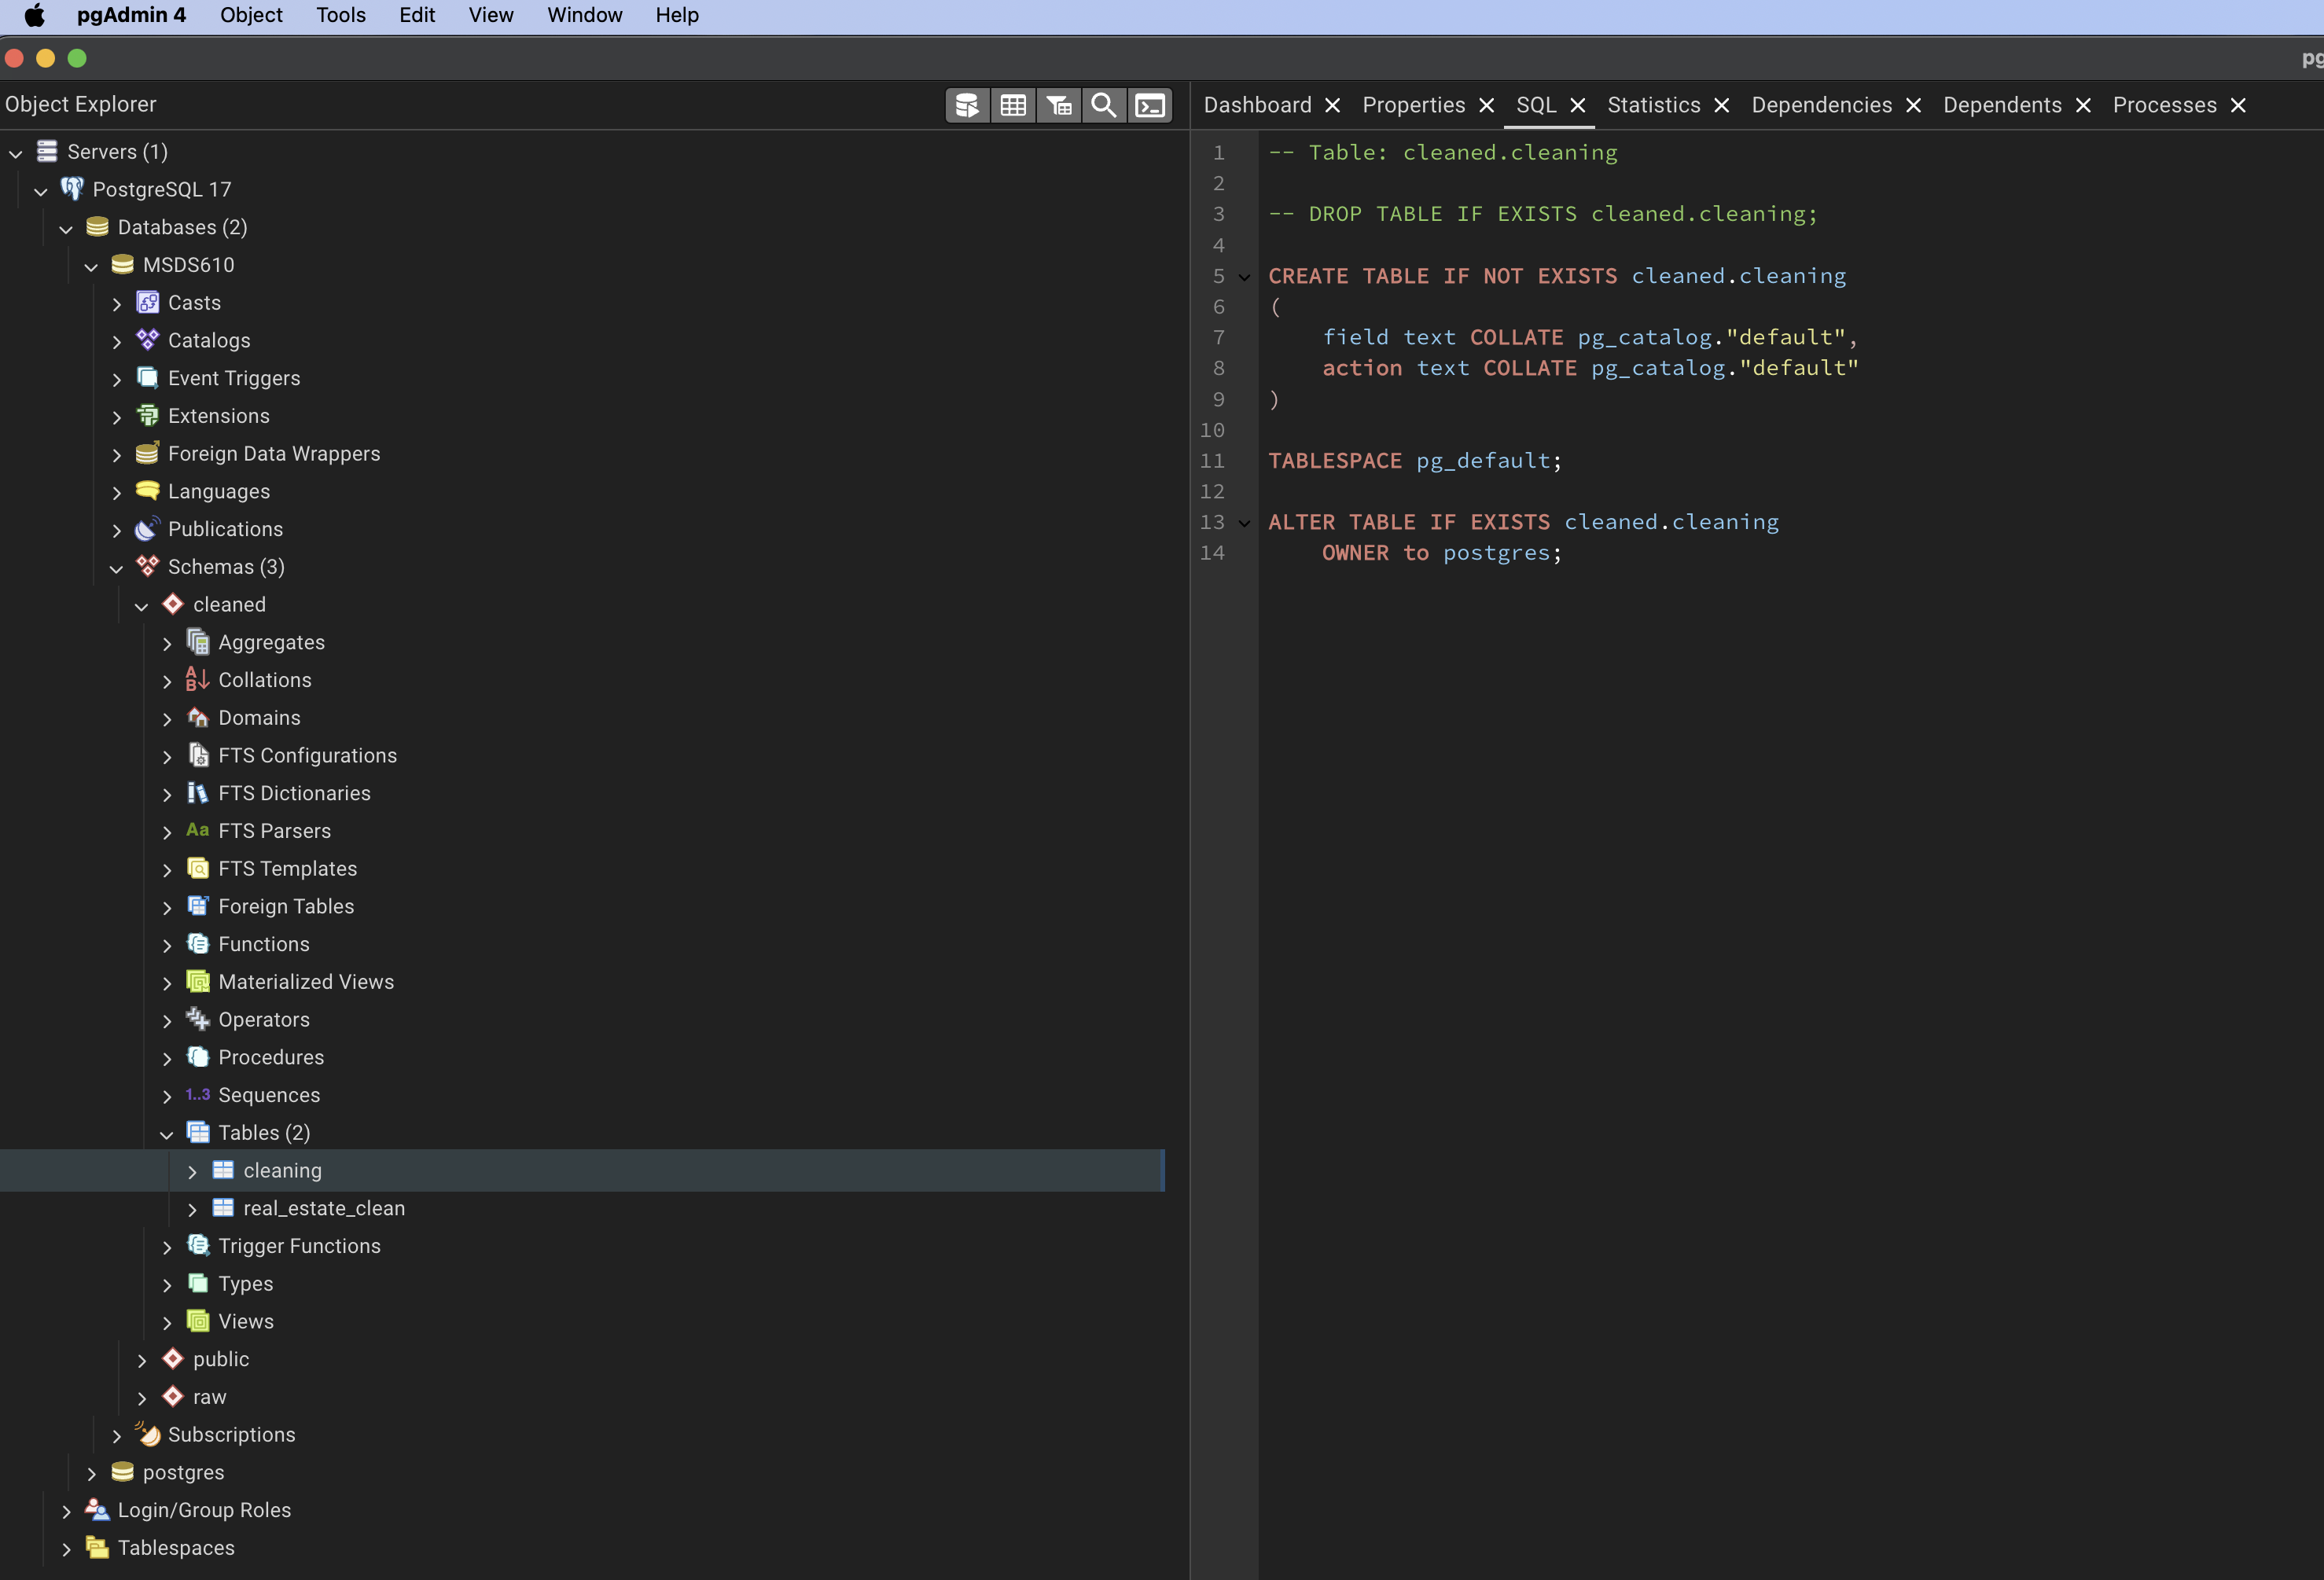

##### The next step here is going to be creating some new features. I'm going to create 2 calculated columns that will show the percentage of the maximum for price and mileage.

In [46]:
sales_data2.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014,gmc,sierra 1500 crew cab slt,3,8,1,57923.0,2,3
28,22590,2010,chevrolet,silverado 1500,3,8,1,71229.0,2,3
29,39590,2020,chevrolet,silverado 1500 crew,3,8,1,19160.0,2,3
30,30990,2017,toyota,tundra double cab sr,3,8,1,41124.0,2,3
31,15000,2013,ford,f-150 xlt,4,6,1,128000.0,3,4


In [47]:
sales_data2.dtypes

price             int64
year              int64
manufacturer     object
model            object
condition         int64
cylinders        object
fuel              int64
odometer        float64
transmission      int64
type              int64
dtype: object

#### I'm going to also remove any outliers from the price and odometer columns. Outside of those two there would not be any potential for outliers.

In [48]:
def remove_outliers_zscore(sales_data2, price, threshold=3):
    z_scores = np.abs((sales_data2[price] - sales_data2[price].mean()) / sales_data2[price].std())
    return sales_data2[z_scores <= threshold]

sales_data3 = remove_outliers_zscore(sales_data2.copy(), 'price')

In [49]:
sales_data3['price'].max()

np.int64(17000000)

In [50]:
def remove_outliers_zscore(sales_data3, odometer, threshold=3):
    z_scores = np.abs((sales_data3[odometer] - sales_data3[odometer].mean()) / sales_data3[odometer].std())
    return sales_data3[z_scores <= threshold]

sales_data4 = remove_outliers_zscore(sales_data3.copy(), 'odometer')

In [51]:
sales_data4['odometer'].max()

np.float64(760000.0)

In [52]:
sales_data4['price_ratio'] = sales_data4['price'] / sales_data4['price'].max()

In [53]:
sales_data4['mileage_ratio'] = sales_data4['odometer'] / sales_data4['odometer'].max()

In [54]:
sales_data4.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type,price_ratio,mileage_ratio
27,33590,2014,gmc,sierra 1500 crew cab slt,3,8,1,57923.0,2,3,0.001976,0.076214
28,22590,2010,chevrolet,silverado 1500,3,8,1,71229.0,2,3,0.001329,0.093722
29,39590,2020,chevrolet,silverado 1500 crew,3,8,1,19160.0,2,3,0.002329,0.025211
30,30990,2017,toyota,tundra double cab sr,3,8,1,41124.0,2,3,0.001823,0.054111
31,15000,2013,ford,f-150 xlt,4,6,1,128000.0,3,4,0.000882,0.168421


# Model Construction

##### Alright, now I'm ready to start construction on this model. I'm going to go with the Random Forest Classifier. I like that algorithm for this because of the diversity of the features in the data. I have some features that are measured based on a scale that I created, which could create a challenge when looking for simililarities of features at different prices. I think those numbers will consistently correlate with similar price points, but with the Random Forest Classifier's multiple decision tree method, I believe I have the best chance at making accurate predictions.  

In [55]:
sales_data5 = sales_data4.drop(['manufacturer', 'model'], axis=1)

In [56]:
sales_data5.head()

,price,year,condition,cylinders,fuel,odometer,transmission,type,price_ratio,mileage_ratio
27,33590,2014,3,8,1,57923.0,2,3,0.001976,0.076214
28,22590,2010,3,8,1,71229.0,2,3,0.001329,0.093722
29,39590,2020,3,8,1,19160.0,2,3,0.002329,0.025211
30,30990,2017,3,8,1,41124.0,2,3,0.001823,0.054111
31,15000,2013,4,6,1,128000.0,3,4,0.000882,0.168421


In [57]:
sales_data5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152150 entries, 27 to 426878
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   price          152150 non-null  int64  
 1   year           152150 non-null  int64  
 2   condition      152150 non-null  int64  
 3   cylinders      152150 non-null  object 
 4   fuel           152150 non-null  int64  
 5   odometer       152150 non-null  float64
 6   transmission   152150 non-null  int64  
 7   type           152150 non-null  int64  
 8   price_ratio    152150 non-null  float64
 9   mileage_ratio  152150 non-null  float64
dtypes: float64(3), int64(6), object(1)
memory usage: 12.8+ MB


In [58]:
sales_data5['cylinders'].value_counts()

cylinders
6      61186
4      44744
8      43402
5       1033
10       954
oth      443
3        313
12        75
Name: count, dtype: int64

In [59]:
oth_cylinders = 'oth'
drop_typos = sales_data5[sales_data5['cylinders'] == oth_cylinders].index
sales_data5 = sales_data5.drop(drop_typos)

In [60]:
sales_data5['cylinders'].value_counts()

cylinders
6     61186
4     44744
8     43402
5      1033
10      954
3       313
12       75
Name: count, dtype: int64

##### If you're wondering what happened here, I ran into some errors and found a couple of issues with the data. I chose to drop manufacturer and model because they were not numerical values and caused an issue with the model. I also found that 443 cars had "oth" cylinders in them. Based on a quick google search it does not seem that "oth" cylinders are in any way related to cars, so I removed those rows.

In [61]:
X = sales_data5.drop(columns=['price'])
y = sales_data5['price']

In [62]:
 X = X.rename(str,axis="columns")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [64]:
classi = RandomForestClassifier(n_estimators=25, random_state=42)
classi.fit(X_train, y_train)

importances = classi.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

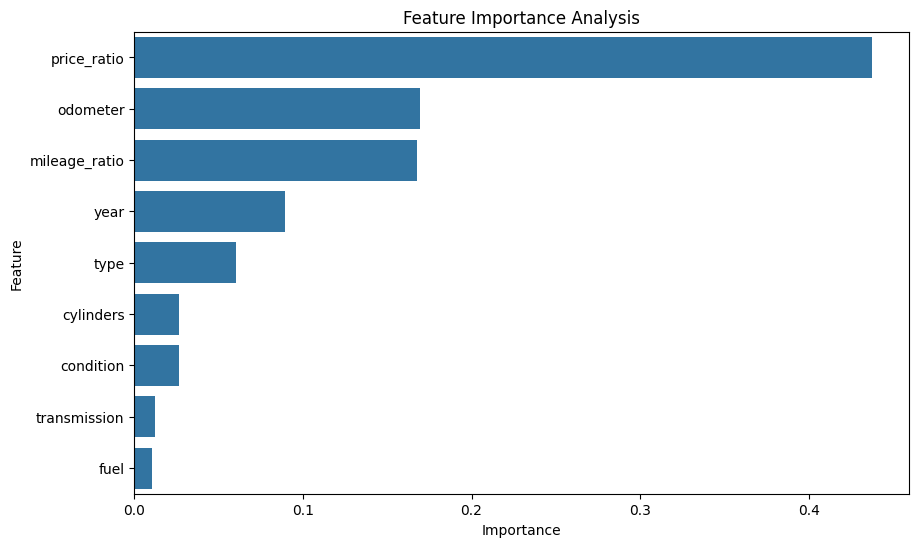

In [65]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance Analysis")
plt.show()

#### Interesting results here. I think the price ratio is listed at the top because it is calculated based on the price. I think it's fair to believe that the mileage of the car has the strongest impact on the price.

In [66]:
import joblib

In [68]:
joblib.dump(classi, "car_sales_forest.joblib") 

['car_sales_forest.joblib']

: 

# Moving on to notebook 2